In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from utils.enhance import img_weighted
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Split dataset

In [8]:
df = pd.read_csv("brain_tumor_dataset/annotations.csv")

# split train test
# use stratify for imbalanced yes, no 
train_df, test_df = train_test_split(df, test_size=0.2, random_state=777, stratify=df.labels)

# split train validation 
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=777, stratify=train_df.labels)

print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)


(161, 2)
(41, 2)
(51, 2)


In [9]:
train_df

,filepaths,labels
36,brain_tumor_dataset/no\43 no.jpg,no
214,brain_tumor_dataset/yes\Y54.jpg,yes
77,brain_tumor_dataset/no\no 92.jpg,no
51,brain_tumor_dataset/no\N15.jpg,no
48,brain_tumor_dataset/no\9 no.jpg,no
...,...,...
103,brain_tumor_dataset/yes\Y103.jpg,yes
191,brain_tumor_dataset/yes\Y30.jpg,yes
209,brain_tumor_dataset/yes\Y49.JPG,yes
250,brain_tumor_dataset/yes\Y97.JPG,yes


In [21]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda image: img_weighted(image))
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(256,256),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=64,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(256,256),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=64,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= valid_df,x_col="filepaths", y_col="labels",
                                    target_size=(256,256),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=64,
                                    shuffle=False
                                   )

Found 161 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.


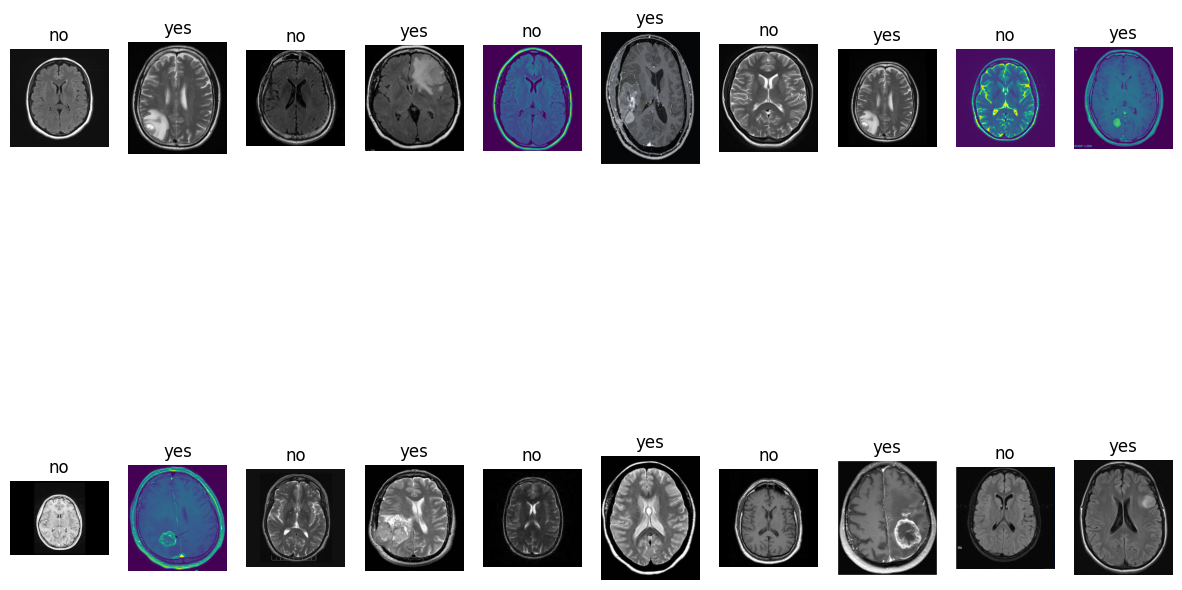

In [11]:
# Define the number of images to display from each class
num_images_per_class = 10

# Get class labels
class_labels = list(train.class_indices.keys())

# Plot images from each class
plt.figure(figsize=(15, 10))
for label in class_labels:
    # Get indices of images belonging to the current class
    indices = train_df[train_df['labels'] == label].index
    
    # Randomly sample a subset of indices if there are more than the desired number of images per class
    indices = np.random.choice(indices, min(num_images_per_class, len(indices)), replace=False)
    
    # Plot images
    for i, idx in enumerate(indices):
        plt.subplot(len(class_labels), num_images_per_class, len(class_labels)*i + class_labels.index(label) + 1)
        plt.imshow(plt.imread(train_df.loc[idx, 'filepaths']))  # Load and plot the image
        plt.title(label)
        plt.axis('off')
plt.show()

In [22]:
class_labels

['no', 'yes']

In [12]:
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception

learning_rate = 0.001
base_model = Xception(weights='imagenet', include_top=False, pooling='max')
x = base_model.output
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adamax(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train, epochs=150, validation_data=val)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Epoch 1/150


c:\Users\pumad\anaconda3\envs\Project\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 50s 17s/step - accuracy: 0.5722 - loss: 1.0816 - val_accuracy: 0.6829 - val_loss: 1.1815
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.8941 - loss: 0.2271 - val_accuracy: 0.7073 - val_loss: 1.3810
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.9607 - loss: 0.0959 - val_accuracy: 0.6585 - val_loss: 1.4884
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 7s/step - accuracy: 0.9542 - loss: 0.1800 - val_accuracy: 0.7073 - val_loss: 1.2366
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - accuracy: 0.9780 - loss: 0.0995 - val_accuracy: 0.7561 - val_loss: 1.0074
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.9847 - loss: 0.0440 - val_accuracy: 0.7805 - val_loss: 0.9197
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.9969 - loss: 0.0088 - val_accuracy: 0.7805 - val_loss: 0.8394
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.9969 - loss: 0.0152 - val_accuracy: 0.7805 - val_loss: 0.7195
Epoch 9/150

In [13]:
# evaluate test data

loss, acc = model.evaluate(test)
print(f"Test loss: {loss}")
print(f"Test Accuracy: {acc}")

c:\Users\pumad\anaconda3\envs\Project\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8627 - loss: 1.1066
Test loss: 1.1066076755523682
Test Accuracy: 0.8627451062202454


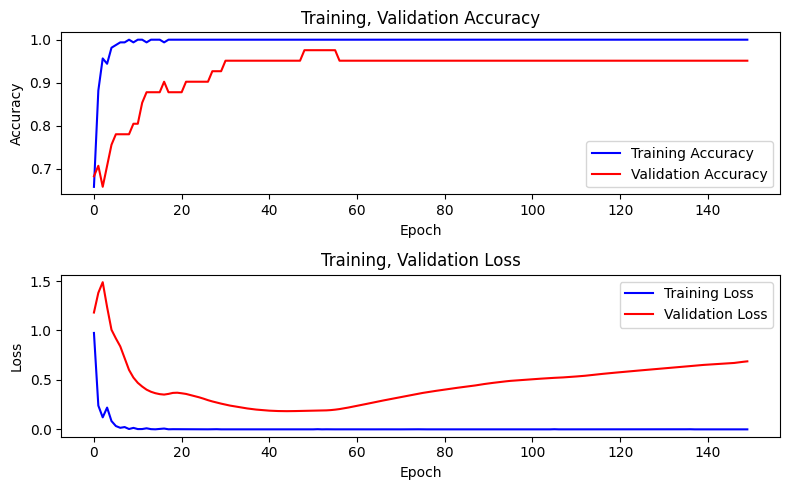

In [19]:
# Visualize metrics

train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Training Accuracy', color="blue")
plt.plot(valid_acc, label="Validation Accuracy", color="red")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training, Validation Accuracy")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_loss, label="Training Loss", color="blue")
plt.plot(valid_loss, label="Validation Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Get predictions for the test data
y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)
print(conf_matrix)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[[19  1]
 [19 12]]


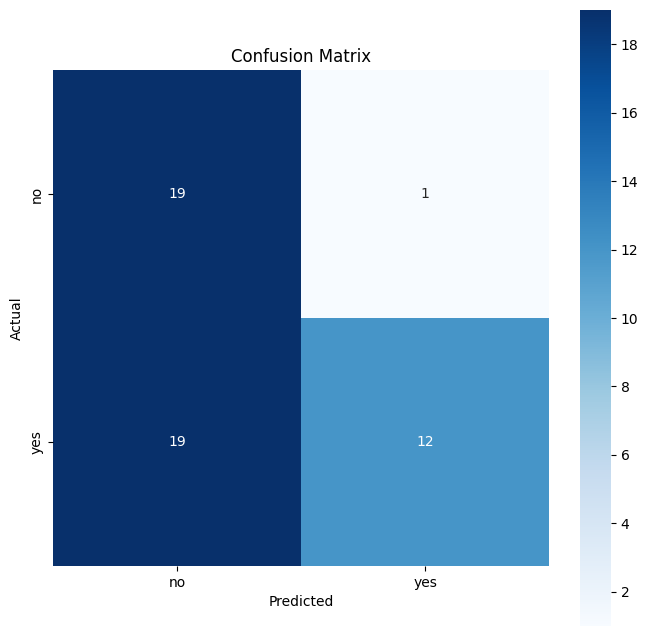

In [22]:

# Plot confusion matrix
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [32]:
# get the final epoch's metrics

final_train_acc = train_acc[-1]
final_train_loss = train_loss[-1]
final_valid_acc = valid_acc[-1]
final_valid_loss = valid_loss[-1]

# save in a csv format
import csv
model_name = "Xception"
regularization = "None"
balancer = "None"

file_name = "Model_evaluation.csv"

with open(file_name, 'w', newline='') as file:
    writer  = csv.writer(file)
    writer.writerow(['Model Name', 'Regularization', 'Balancer', 'Train Accuracy', 'Train Loss', 'Valid Accuracy', 'Valid Loss', 'Test Accuracy', 'Test Loss'])
    writer.writerow([model_name, regularization, balancer, final_train_acc, final_train_loss, final_valid_acc, final_valid_loss, acc, loss])


In [ ]:
model_eval = pd.read_csv("Model_evaluation.csv")
model_eval 

,Model Name,Regularization,Balancer,Train Accuracy,Train Loss,Valid Accuracy,Valid Loss,Test Accuracy,Test Loss
0,Xception,NaN,NaN,1.0,0.000033,0.951219,0.687955,0.862745,1.106608
